# POC FLEET - Pipeline de Inferência e Análise de Zonas com YOLOv8

**Objetivo:** Este notebook carrega um modelo YOLOv8 treinado para detecção de motocicletas (`best.pt`), realiza inferência em uma imagem de teste, extrai as localizações das motos detectadas, aplica clusterização K-Means para identificar agrupamentos e visualiza esses agrupamentos como sugestões de zonas no pátio.


In [ ]:
!pip install ultralytics -q
!pip install opencv-python -q
!pip install matplotlib -q
!pip install scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from google.colab import drive

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
EXPERIMENT_NAME = 'yolov8n_motorbike_detector_run1'
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab_Notebooks'
PROJECT_FOLDER_NAME = 'fleet_cv'

In [ ]:
project_base_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, PROJECT_FOLDER_NAME)
test_media_images_path = os.path.join(project_base_path, 'test_media/images/')
path_to_best_pt = os.path.join(project_base_path, 'trained_models/yolo_detector/', EXPERIMENT_NAME, 'weights/best.pt')

In [ ]:
IMAGE_TO_ANALYZE = '14.jpg' # Ajustar para a imagem que o modelo vai analisar (tem que estar na pasta test_media/images)
NUM_CLUSTERS = 3
CONF_THRESHOLD_PREDICT = 0.15

In [ ]:
print(f"Carregando modelo de: {path_to_best_pt}")
model = YOLO(path_to_best_pt)

Carregando modelo de: /content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/yolov8n_motorbike_detector_run1/weights/best.pt


In [ ]:
print(f"Imagem para análise: {os.path.join(test_media_images_path, IMAGE_TO_ANALYZE)}")
print(f"Número de clusters (zonas) a serem identificados: {NUM_CLUSTERS}")

Imagem para análise: /content/drive/MyDrive/Colab_Notebooks/fleet_cv/test_media/images/14.jpg
Número de clusters (zonas) a serem identificados: 3


## Passo 1: Realizar Detecção na Imagem e Extrair Centros das Motos

In [ ]:
image_path = os.path.join(test_media_images_path, IMAGE_TO_ANALYZE)
original_image_cv2 = cv2.imread(image_path)

print(f"\nRodando predição em: {image_path}...")
results = model.predict(source=image_path, conf=CONF_THRESHOLD_PREDICT, save=False, verbose=False)

result = results[0]
image_with_yolo_detections_bgr = result.plot()
boxes_xyxy = result.boxes.xyxy.cpu().numpy()

detected_centers = []
if boxes_xyxy.shape[0] > 0:
  for box in boxes_xyxy:
    x_min, y_min, x_max, y_max = box
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    detected_centers.append([center_x, center_y])
  detected_centers_np = np.array(detected_centers)
  print(f"Número de motos detectadas: {len(detected_centers_np)}")
else:
  print(f"Nenhuma moto detectada em {IMAGE_TO_ANALYZE} com conf={CONF_THRESHOLD_PREDICT}.")
  detected_centers_np = np.array([])
  if original_image_cv2 is not None:
    image_with_yolo_detections_bgr = original_image_cv2.copy()
  else:
    image_with_yolo_detections_bgr = np.zeros((100,100,3), dtype=np.uint8)

print("Centros das motos detectadas (X, Y):\n", detected_centers_np)


Rodando predição em: /content/drive/MyDrive/Colab_Notebooks/fleet_cv/test_media/images/14.jpg...
Número de motos detectadas: 12
Centros das motos detectadas (X, Y):
 [[     139.43      479.45]
 [     456.85      426.96]
 [     931.14      429.34]
 [     907.36      473.77]
 [     485.74      423.41]
 [     172.81      467.07]
 [     445.84      416.26]
 [     652.87      387.52]
 [     191.06      457.32]
 [     462.76      429.13]
 [     183.54      472.61]
 [     498.75       419.2]]


## Passo 2: Visualizar Imagem com as Detecções YOLO

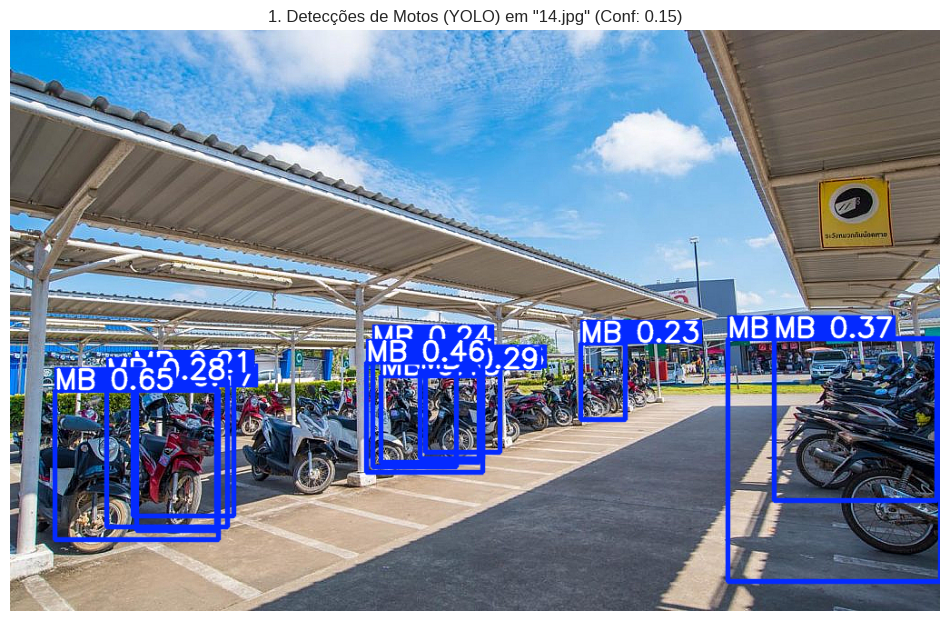

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))

image_rgb_yolo_plot = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_yolo_plot)

plt.title(f'1. Detecções de Motos (YOLO) em "{IMAGE_TO_ANALYZE}" (Conf: {CONF_THRESHOLD_PREDICT})')
plt.axis('off')
plt.show()

## Passo 3: Aplicar Clusterização K-Means nos Centros Detectados

In [ ]:
cluster_labels = None
cluster_centers = None

if len(detected_centers_np) >= NUM_CLUSTERS:
  kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
  cluster_labels = kmeans.fit_predict(detected_centers_np)
  cluster_centers = kmeans.cluster_centers_

  print(f"\n--- Resultados da Clusterização para {NUM_CLUSTERS} Clusters ---")
  for i in range(NUM_CLUSTERS):
    print(f"Zona Sugerida {i+1} (Centroide): X={cluster_centers[i,0]:.0f}, Y={cluster_centers[i,1]:.0f}")
  print("Labels dos clusters para cada moto:\n", cluster_labels)
else:
  print(f"Não foi possível realizar a clusterização: número de motos detectadas ({len(detected_centers_np)}) é menor que o número de clusters desejado ({NUM_CLUSTERS}).")


--- Resultados da Clusterização para 3 Clusters ---
Zona Sugerida 1 (Centroide): X=500, Y=417
Zona Sugerida 2 (Centroide): X=172, Y=469
Zona Sugerida 3 (Centroide): X=919, Y=452
Labels dos clusters para cada moto:
 [1 0 2 2 0 1 0 0 1 0 1 0]


## Passo 4: Visualizar Clusters em Gráfico de Dispersão

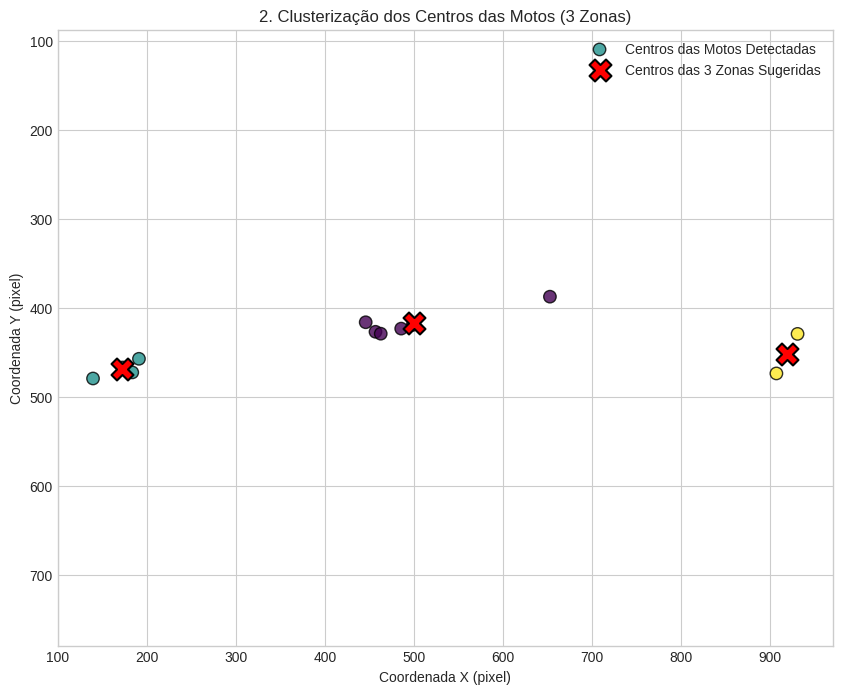

In [ ]:
if detected_centers_np.any() and cluster_labels is not None and cluster_centers is not None:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))

    plt.scatter(
        detected_centers_np[:, 0],
        detected_centers_np[:, 1],
        c=cluster_labels,
        cmap='viridis',
        s=80,
        alpha=0.8,
        edgecolor='black',
        label='Centros das Motos Detectadas'
    )
    plt.scatter(
        cluster_centers[:, 0],
        cluster_centers[:, 1],
        c='red',
        marker='X',
        s=250,
        edgecolor='black',
        linewidth=1.5,
        label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas'
    )

    plt.title(f'2. Clusterização dos Centros das Motos ({NUM_CLUSTERS} Zonas)')
    plt.xlabel("Coordenada X (pixel)")
    plt.ylabel("Coordenada Y (pixel)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()
else:
    print("Não há dados de clusterização suficientes ou válidos para plotar o gráfico de dispersão.")

## Passo 5: Visualizar Zonas Sugeridas (Centroides) na Imagem com Detecções

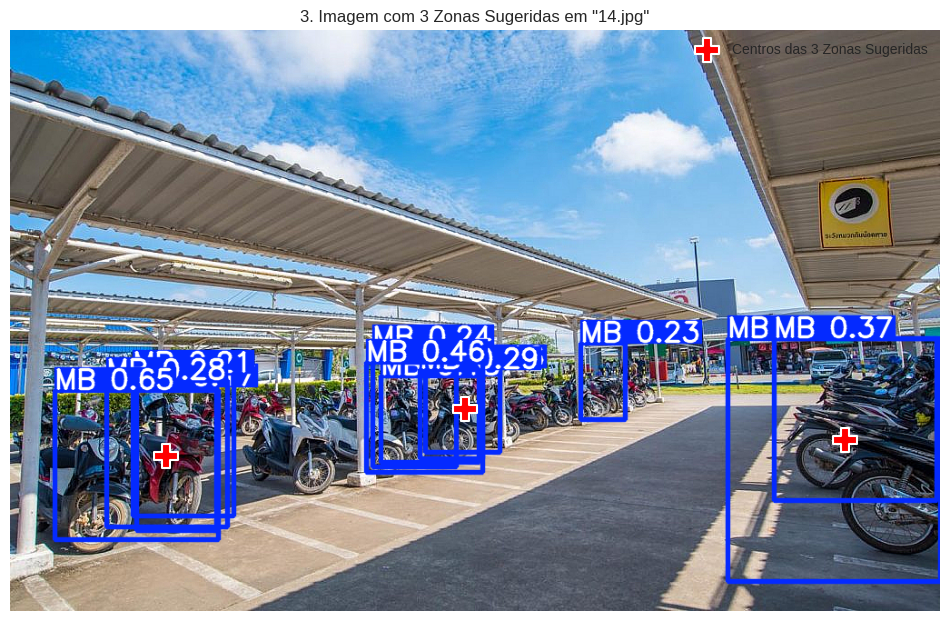

In [ ]:
if image_with_yolo_detections_bgr is not None and cluster_centers is not None:
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.figure(figsize=(12, 10))

  image_rgb_yolo_plot_for_zones = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb_yolo_plot_for_zones)

  plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='P',
    s=300,
    edgecolor='white',
    linewidth=1.5,
    label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas',
    zorder=5
  )

  plt.title(f'3. Imagem com {NUM_CLUSTERS} Zonas Sugeridas em "{IMAGE_TO_ANALYZE}"')
  plt.legend(loc='best')
  plt.axis('off')
  plt.show()
else:
  print("Não foi possível plotar a imagem com as zonas sugeridas (dados de cluster ou imagem faltando).")